# Bayesian Phase Difference Estimation (BPDE) Algorithm for Calculating Numerical Energy Gradient

The Bayesian Phase Difference Estimation (BPDE) algorithm [[1](#Sugisaki2022),[2](#Wiebe2016)] is a quantum algorithm for calculating the energy difference between two electronic states in a given Hamiltonian.

In quantum chemical calculations, molecular geometry optimization is one of the most fundamental computations. In a geometry optimization calculation, the initial coordinates of the nuclei in the molecule are provided first, then the coordinates are iteratively updated to minimize the molecule's energy. The motivation for performing a geometry optimization is to obtain a physically meaningful structure, as the optimized geometry typically reflects how a substance exists in nature. This structure can then be utilized to investigate vibrational and thermodynamic properties and chemical reactions [[3](#EnergyMinimization)].

Geometry optimization calculations requires to compute the derivative of the energy with respect to the nuclear coordinates. By calculating the energy difference between two molecular structures using the BPDE algorithm, this derivative can be directly obtained using the finite difference method.

In this tutorial, we will explain how the BPDE algorithm computes the energy difference based on Sugisaki et al.'s paper "Quantum Algorithm for Numerical Energy Gradient Calculations at the Full Configuration Interaction Level of Theory" [[1](#Sugisaki2022)].

Let's start by importing all the necessary libraries.

In [1]:
from time import perf_counter
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

from classiq import *
from classiq.applications.chemistry import *
from classiq.execution import *
from classiq.qmod.quantum_function import QFunc

SEED = 42
PAULI_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

# for testing purposes
QMODS = []
QPROGS = []
DURATIONS = []

Next, let's define the target diatomic molecule and write out the Hamiltonian. Here, we specify the hydrogen molecule.

In [2]:
# define your molecule problem


def get_electronic_structure_problem(internuclear_distance: float) -> MoleculeProblem:
    molecule = Molecule(
        atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, internuclear_distance))]
    )
    return MoleculeProblem(
        molecule=molecule,
        basis="sto3g",
        mapping="jordan_wigner",
        z2_symmetries=True,
        freeze_core=True,
    )


gs_problem = get_electronic_structure_problem(internuclear_distance=0.74)
operator = gs_problem.generate_hamiltonian()
print("Your Hamiltonian is", operator.show(), sep="\n")

Your Hamiltonian is
-1.042 * I
-0.790 * Z
+0.181 * X


Let's vary the interatomic distance and plot the potential energy surface. In the case of the hydrogen molecule, we can see that it is most stable around 0.74 Å.

  0%|          | 0/30 [00:00<?, ?it/s]

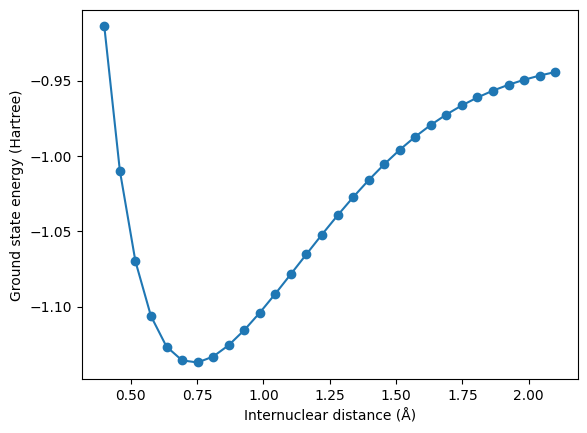

In [3]:
total_energies = []
distances = np.linspace(0.4, 2.1, 30)
for distance in tqdm(distances):
    problem = get_electronic_structure_problem(distance)
    operator = problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result = np.real(min(w))
    result += 1 / (distance * 1.889726)  # Nuclear repulsion energy
    total_energies.append(result)

plt.plot(distances, total_energies, "o-")
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Ground state energy (Hartree)")
plt.show()

Let's visualize the energy gradient $dE/dr$ using the calculated energy. Energy gradient refers to the rate and direction of change in energy with respect to nuclear coordinates. Since we have only one parameter $r$, the internuclear distance between two hydrogen atoms, the energy gradient at $r=R$ is simply a scalar, and it represents the difference between the ground state energies at a specific point $R$ of the Hamiltonian that depends on $R$.

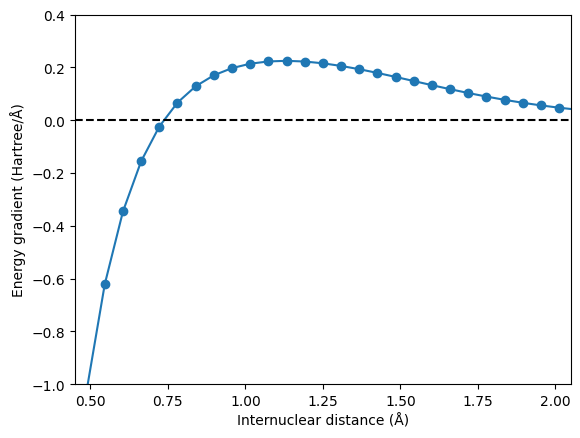

In [4]:
dr = distances[1] - distances[0]
distances_between = (np.array(distances) + dr / 2)[:-1]
total_energy_gaps = [
    (total_energies[i + 1] - total_energies[i]) / dr
    for i in range(len(total_energies) - 1)
]
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

Next, we explain how to calculate the energy gradient $dE/dR$ using the BPDE algorithm. In this algorithm, we construct the following circuit.

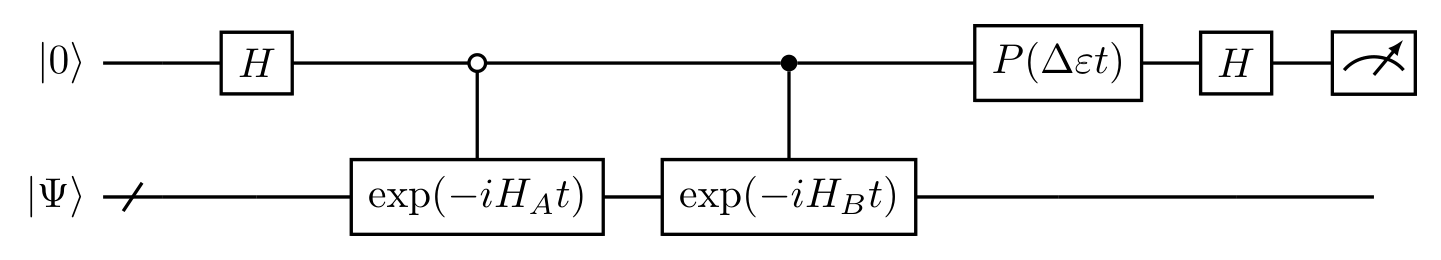

Here, $P(\phi)$ represents the following single-qubit gate.
$$
P(\phi) = \begin{pmatrix}
1 & 0 \\
0 & e^{i \phi}
\end{pmatrix}
$$

Let $|\Psi^{(A)}_0\rangle$ be the ground state of the Hamiltonian $H_A$, and $|\Psi^{(B)}_0\rangle$ be the ground state of the Hamiltonian $H_B$. Suppose after applying a Hadamard gate, the quantum state is given by  

$$
\frac{1}{\sqrt{2}} (|0\rangle \otimes |\Psi^{(A)}_0\rangle + |1\rangle \otimes |\Psi^{(B)}_0\rangle)
$$

In this case, the quantum state evolves as follows:  

$$
\begin{align*}
\frac{1}{\sqrt{2}} (|0\rangle \otimes |\Psi^{(A)}_0\rangle + |1\rangle \otimes |\Psi^{(B)}_0\rangle) &\xrightarrow{\text{controlled-}e^{-iH_At},\ \text{controlled-}e^{-iH_Bt}} \frac{1}{\sqrt{2}} (|0\rangle \otimes e^{-iE^{(A)}_0t}|\Psi^{(A)}_0\rangle + |1\rangle \otimes e^{-iE^{(B)}_0t}|\Psi^{(B)}_0\rangle) \\  
&\xrightarrow{P(\Delta\varepsilon t)} \frac{1}{\sqrt{2}} (e^{-iE^{(A)}_0t}|0\rangle \otimes |\Psi^{(A)}_0\rangle + e^{-i(E^{(B)}_0-\Delta\varepsilon)t}|1\rangle \otimes |\Psi^{(B)}_0\rangle) \\  
&\xrightarrow{H} \frac{1}{2} [(e^{-iE^{(A)}_0t} + e^{-i(E^{(B)}_0-\Delta\varepsilon)t}) |0\rangle \otimes |\Psi^{(A)}_0\rangle + (e^{-iE^{(A)}_0t} - e^{-i(E^{(B)}_0-\Delta\varepsilon)t}) |1\rangle \otimes |\Psi^{(B)}_0\rangle]  
\end{align*}
$$

At the measurement stage, the probability of measuring the zero state is  

$$
\text{Prob}(0) = \frac{1}{2} [1 + \cos\{(E^{(B)}_0 - E^{(A)}_0 - \Delta\varepsilon)t\}]
$$

which reaches its maximum when $\Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0$, because $\max\{\text{Prob}(0)\} = \frac{1}{2} [1 + \cos\{(\Delta\varepsilon - \Delta\varepsilon)t\}] = \frac{1}{2} [1 + \cos(0)] = 1$. Therefore, in the BPDE algorithm, we find the $\Delta\varepsilon$ that maximizes the probability of measuring the zero state to equal the energy difference.
Setting the time $t$ appropriately, which acts as a scaling factor of the Hamiltonian, is important, and we will explain this later.

It is not necessary to input a perfect ground-state wavefunction. Any wavefunction $|\Psi\rangle$ can be expanded in terms of the eigenfunctions $|\Psi^{(A)}_j\rangle$ and $|\Psi^{(B)}_k\rangle$ of each Hamiltonian as follows:  

$$
|\Psi\rangle = \sum_j c_j |\Psi^{(A)}_j\rangle = \sum_k d_k |\Psi^{(B)}_k\rangle  
$$

Then, the probability of measuring the zero state is given by  

$$
\text{Prob}(0) = \frac{1}{2} \left[ 1 + \sum_{j,k} |c_j|^2|d_k|^2\cos\{(E^{(B)}_k - E^{(A)}_j - \Delta\varepsilon)t\} \right]
$$

If the overlap between the input wavefunction and the ground-state wavefunction is sufficiently large, the probability should reach its maximum when $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 $, just as before.  

Here, we use the Hartree-Fock state for $|\Psi\rangle$.

If we take $H_B$ as the Hamiltonian of the hydrogen molecule at an internuclear distance of $R + \Delta r /2$ and $H_A$ as the Hamiltonian at $R - \Delta r /2$, we can determine the energy difference between the two ground states.  

Thus, using the finite difference method, the energy gradient $dE/dr$ can be approximated as  

$$
\frac{dE}{dr} \approx \frac{E(R + \Delta r /2) - E(R - \Delta r /2)}{\Delta r}
$$

In [5]:
def pauli_str_to_enums(pauli):
    return [PAULI_DICT[s] for s in pauli]


def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]


# Build the quantum circuit
def get_qfunc(
    molecule_problem_a: MoleculeProblem,
    molecule_problem_b: MoleculeProblem,
    time: float,
    trotter_step_size: float = 0.5,
) -> QFunc:
    # Using the original pauli_list raises RecursionError, so we convert it
    pauli_list_a = molecule_problem_a.generate_hamiltonian().pauli_list
    hamiltonian_a = pauli_list_to_hamiltonian(pauli_list_a)
    pauli_list_b = molecule_problem_b.generate_hamiltonian().pauli_list
    hamiltonian_b = pauli_list_to_hamiltonian(pauli_list_b)

    @qfunc
    def main(readout: Output[QBit], delta_e: CReal):
        state = QArray("state")
        allocate(len(pauli_list_a[0][0]), state)
        allocate(1, readout)

        # Initialize the state to Hartree-Fock state
        molecule_hartree_fock(molecule_problem_to_qmod(molecule_problem_a), state)

        H(readout)
        control(
            readout,
            lambda: suzuki_trotter(
                hamiltonian_b,
                evolution_coefficient=time,
                order=2,
                repetitions=int(np.ceil(time / trotter_step_size)),
                qbv=state,
            ),
            lambda: suzuki_trotter(
                hamiltonian_a,
                evolution_coefficient=time,
                order=2,
                repetitions=int(np.ceil(time / trotter_step_size)),
                qbv=state,
            ),
        )
        PHASE(theta=delta_e * time, target=readout)
        H(readout)

    return main

In [6]:
# Test the quantum circuit


internuclear_distance = 1.0
delta_r = 0.0025
time = 1.0
num_shots = 1_000_000

qmod = get_qfunc(
    molecule_problem_a=get_electronic_structure_problem(
        internuclear_distance - delta_r / 2
    ),
    molecule_problem_b=get_electronic_structure_problem(
        internuclear_distance + delta_r / 2
    ),
    time=time,
)
qmod = create_model(
    qmod,
    execution_preferences=ExecutionPreferences(num_shots=num_shots, random_seed=SEED),
    out_file=f"bpde",
)
QMODS.append(qmod)
qprog = synthesize(qmod)
QPROGS.append(qprog)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2w4BWuF85JvbMC7Guil9fMhMeRj?login=True&version=0.75.0


Executing the code above yields the following circuit.

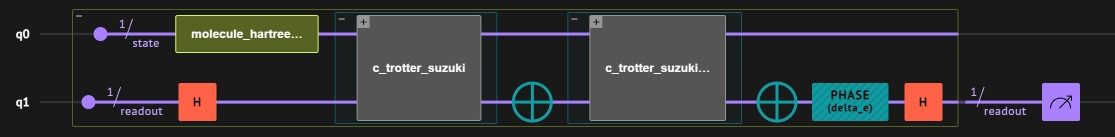

In [7]:
delta_es = [0.1, 0.2, 0.3]

with ExecutionSession(qprog) as execution_session:
    hamiltonian = [PauliTerm(pauli=[Pauli.Z], coefficient=1.0)]
    batch_estimate_result = execution_session.batch_estimate(
        hamiltonian,
        [{"delta_e": delta_e} for delta_e in delta_es],
    )

[batch_estimate_result[i].value.real for i in range(len(delta_es))]

[0.995292, 0.980162, 0.95602]

Now let's verify that this quantum circuit can actually calculate the energy gradient.

In [8]:
def get_zero_state_measurement_probabilities(
    R: float,
    delta_r: float,
    time: float,
    delta_es: float,
    num_shots: int = 1_000_000,  # maximum number of shots classiq can handle
) -> float:
    global QMODS, QPROGS, DURATIONS
    time_start = perf_counter()
    qmod = get_qfunc(
        molecule_problem_a=get_electronic_structure_problem(R - delta_r / 2),
        molecule_problem_b=get_electronic_structure_problem(R + delta_r / 2),
        time=time,
    )
    qmod = create_model(
        qmod,
        execution_preferences=ExecutionPreferences(
            num_shots=num_shots, random_seed=SEED
        ),
    )
    qprog = synthesize(qmod)
    with ExecutionSession(qprog) as execution_session:
        pauli_z = [PauliTerm(pauli=[Pauli.Z], coefficient=1.0)]
        batch_estimate_result = execution_session.batch_estimate(
            pauli_z, [{"delta_e": delta_e} for delta_e in delta_es]
        )
    time_end = perf_counter()
    QMODS.append(qmod)
    QPROGS.append(qprog)
    DURATIONS.append(time_end - time_start)

    return [batch_estimate_result[i].value.real for i in range(len(delta_es))]

Max probability of measuring |0>: 0.9981439999999999 at Δε = 0.00175


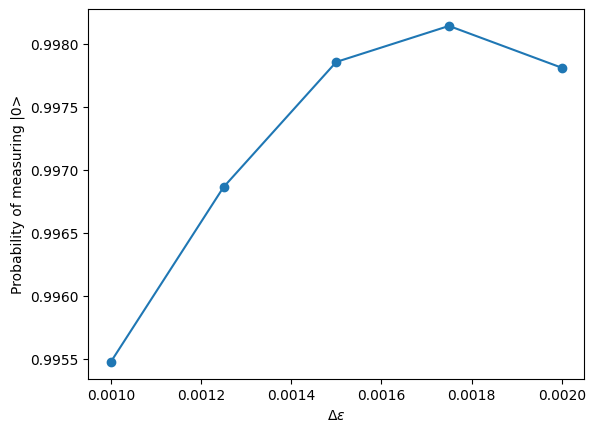

In [9]:
# Calculate the energy gradient by varying the Δε


# parameters
internuclear_distance = 1.0
time = 100.0
delta_r = 0.0025
delta_es = np.linspace(0.001, 0.002, 5)

# calculate the probability of measuring |0> for each delta_e
probs = get_zero_state_measurement_probabilities(
    internuclear_distance, delta_r, time, delta_es
)
print(
    "Max probability of measuring |0>:",
    max(probs),
    "at Δε =",
    delta_es[np.argmax(probs)],
)

# Plot the results
plt.plot(delta_es, probs, "o-")
plt.xlabel(r"$\Delta\varepsilon$")
plt.ylabel("Probability of measuring |0>")
plt.show()

Now, let's visualize the obtained gradient on the previously plotted energy gradient graph.

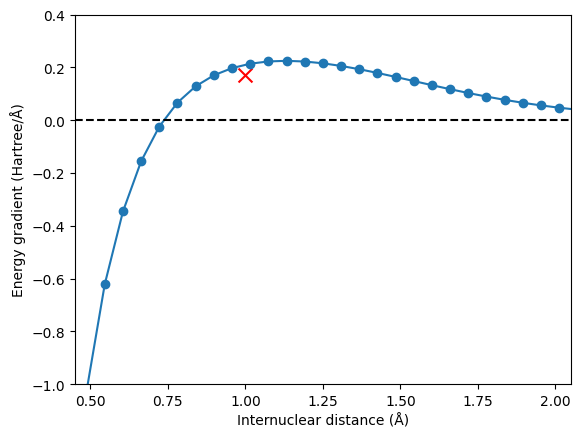

In [10]:
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
# Add the energy gradient from the nuclear repulsion term
plt.scatter(
    [internuclear_distance],
    [delta_es[np.argmax(probs)] / delta_r - 1 / (internuclear_distance**2 * 1.889726)],
    marker="x",
    color="red",
    s=100,
)
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

From the above, we can see that when the probability of measuring the zero state is maximized, $\Delta\varepsilon / \Delta r \approx dE/dR$ holds.  

Here, note that the Coulomb repulsion between nuclei is not included in the Hamiltonian, so to obtain the complete energy gap, this Coulomb repulsion term must be added afterward.

In the previous calculation, we set $ t = 100 $, but this time parameter $ t $ must be appropriately chosen. In the explanation of the algorithm, we stated that the goal is to maximize the probability of measuring the zero state, and that this probability is given by the following expression:

$$
\text{Prob}(0) = \frac{1}{2} \left[ 1 + \sum_{j,k} |c_j|^2|d_k|^2\cos\{(E^{(B)}_k - E^{(A)}_j - \Delta\varepsilon)t\} \right]
$$

Here, it is important to note that the value of $ \Delta\varepsilon $ that maximizes $ \text{Prob}(0) $ is not only $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 $, but can also be $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 + 2n\pi / t \quad (n: \text{any integer}) $.

From this, one might think that setting $ t $ to an extremely small value would be the correct strategy. The reasoning is that when $ t $ is small, the other solutions become extremely large or small, making it clear that they are physically unrealistic. However, this is not necessarily the right strategy. This is because the number of times we can measure the quantum circuit is finite, and if $ t $ is too small, the probability will not vary significantly even when $ \Delta\varepsilon $ is changed. Let's actually try changing $ t $ and confirm this.

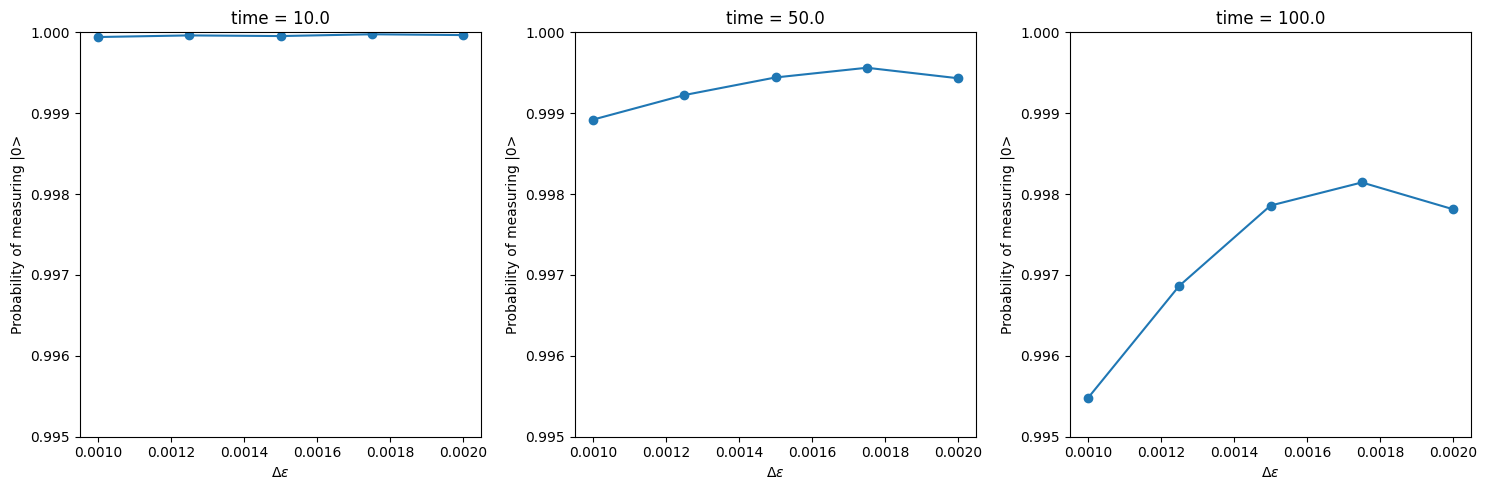

In [11]:
# parameters
internuclear_distance = 1.0
times = [10.0, 50.0, 100.0]
delta_r = 0.0025
delta_es = np.linspace(0.001, 0.002, 5)

fig, axes = plt.subplots(1, len(times), figsize=(15, 5))
for i, time in enumerate(times):
    # calculate the probability of measuring |0> for each delta_e
    probs = get_zero_state_measurement_probabilities(
        internuclear_distance, delta_r, time, delta_es
    )
    axes[i].plot(delta_es, probs, "o-")
    axes[i].set_xlabel(r"$\Delta\varepsilon$")
    axes[i].set_ylabel("Probability of measuring |0>")
    axes[i].set_title(f"time = {time:.1f}")
    axes[i].set_ylim(0.995, 1)

plt.tight_layout()
plt.show()

As can be seen from the graph above, when the value of $ t $ is made small, the probability hardly changes with respect to $ \Delta\varepsilon $, making it difficult to determine where the maximum is. Therefore, the correct strategy is to initially use a small $ t $ to estimate the region where $ \Delta\varepsilon $ reaches its maximum and narrow down the range of $ \Delta\varepsilon $ to consider. Then, by gradually increasing $ t $, the changes in probability with respect to $ \Delta\varepsilon $ become more pronounced, allowing us to identify the value of $ \Delta\varepsilon $ that satisfies $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 $.

This optimization process can be carried out using Bayesian optimization. Specifically, the optimization proceeds as follows:

1. Estimate the region where the solution $ \Delta\varepsilon = E^{(B)}_0 - E^{(A)}_0 $ lies, and assume a Gaussian distribution with mean $ \mu_{\text{prior}} $ and standard deviation $ \sigma_{\text{prior}} $.
2. Sample $ m $ values of $ \Delta\varepsilon $ from the range $ \mu_{\text{prior}} - \sigma_{\text{prior}} $ to $ \mu_{\text{prior}} + \sigma_{\text{prior}} $.
3. Fit a Gaussian distribution to the obtained measurement probabilities and their corresponding $ \Delta\varepsilon $ values.
4. Compute the new posterior parameters $ \mu_{\text{posterior}} $ and $ \sigma_{\text{posterior}} $ from the product of the fitted Gaussian and the original prior distribution.
5. Update $t$.
6. Repeat the process until $ \sigma_{\text{posterior}} $ becomes smaller than a predefined threshold (in this case, $ E_{\text{threshold}} = 0.001 $).
7. $ \mu_{\text{posterior}} / \Delta r $ is the energy gradient we want to calculate.

In [12]:
# Define a prior distribution


# We will use a Gaussian distribution for the prior distribution
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the parameters for the Gaussian distribution
prior_a = 1.0  # amplitude of the Gaussian
prior_mu = 0.0  # mean of the prior distribution
prior_sigma = 0.01  # standard deviation of the prior distribution
popt = [prior_a, prior_mu, prior_sigma]
print(f"Initial guess: mu={prior_mu}, sigma={prior_sigma}")

# Define the parameters for the simulation
n_samples = 5  # number of samples to take for each iteration
# n_samples = 21  # the paper uses 21 samples, but it is too slow
init_time = 2.0
energy_threshold = 0.001  # threshold for convergence
delta_r = 0.0025
internuclear_distance = 1.0

# Initial samples
x_data = np.linspace(prior_mu - prior_sigma, prior_mu + prior_sigma, n_samples)
y_data = np.array(
    get_zero_state_measurement_probabilities(
        internuclear_distance, delta_r, init_time, x_data
    )
)

# Maximum number of iterations
num_iterations = 30

bpde_duration = 0.0

for i in tqdm(range(num_iterations)):
    # Fit the obtained data to a Gaussian
    popt, _ = curve_fit(gaussian, x_data, y_data, p0=[1.0, prior_mu, prior_sigma])

    a_fit, mu_fit, sigma_fit = popt

    # Obtain the posterior distribution
    posterior_mu = (prior_mu / prior_sigma**2 + mu_fit / sigma_fit**2) / (
        1 / prior_sigma**2 + 1 / sigma_fit**2
    )
    posterior_sigma = np.sqrt(1 / (1 / prior_sigma**2 + 1 / sigma_fit**2))
    bpde_duration += DURATIONS[-1]
    print(
        f"Iteration {i + 1}, Posterior mu: {posterior_mu:.5f}, "
        f"Posterior sigma: {posterior_sigma:.5f}, Duration: {bpde_duration:.2f}s"
    )
    if posterior_sigma < energy_threshold:
        print("Convergence achieved.")
        break

    # Decide the next sampling points
    init_time = 1.8 / posterior_sigma  # this condition was derived empirically
    prior_mu = posterior_mu
    prior_sigma = posterior_sigma
    x_data = np.linspace(prior_mu - prior_sigma, prior_mu + prior_sigma, n_samples)
    y_data = np.array(
        get_zero_state_measurement_probabilities(
            internuclear_distance, delta_r, init_time, x_data
        )
    )

print(f"Estimated optimal value: mu={posterior_mu:.5f}, sigma={posterior_sigma:.5f}")

Initial guess: mu=0.0, sigma=0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 1, Posterior mu: 0.00000, Posterior sigma: 0.01000, Duration: 9.65s
Iteration 2, Posterior mu: 0.00160, Posterior sigma: 0.00367, Duration: 49.93s
Iteration 3, Posterior mu: 0.00177, Posterior sigma: 0.00138, Duration: 130.06s
Iteration 4, Posterior mu: 0.00187, Posterior sigma: 0.00052, Duration: 316.48s
Convergence achieved.
Estimated optimal value: mu=0.00187, sigma=0.00052


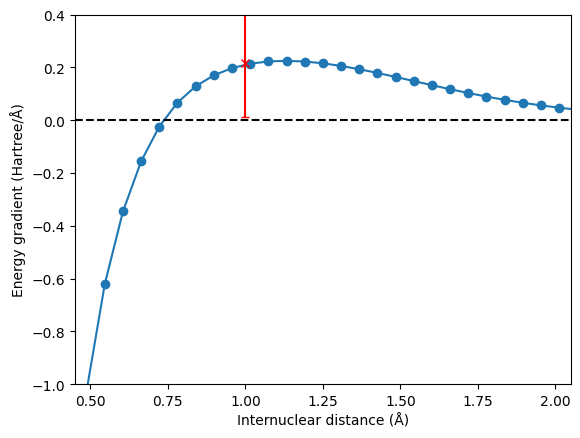

In [13]:
plt.plot(distances_between, total_energy_gaps, "o-")
plt.hlines(0, 0.45, 2.05, linestyles="dashed", colors="k")
# Add the energy gradient from the nuclear repulsion term
calculated_energy_gradient = posterior_mu / delta_r - 1 / (
    internuclear_distance**2 * 1.889726
)
plt.errorbar(
    [internuclear_distance],
    [calculated_energy_gradient],
    yerr=[
        posterior_sigma / delta_r
    ],  # errorbar is the standard deviation of the posterior distribution divided by delta_r
    marker="x",
    color="red",
    capsize=3,
)
plt.xlim(0.45, 2.05)
plt.ylim(-1.0, 0.4)
plt.xticks(np.arange(0.5, 2.1, 0.25))
plt.xlabel("Internuclear distance (Å)")
plt.ylabel("Energy gradient (Hartree/Å)")
plt.show()

## References

<a id='Sugisaki2022'>[1]</a>: [Sugisaki, K., Wakimoto, H., Toyota, K., Sato, K., Shiomi, D., & Takui, T. (2022). Quantum algorithm for numerical energy gradient calculations at the full configuration interaction level of theory. The Journal of Physical Chemistry Letters, 13(48), 11105-11111.](https://pubs.acs.org/doi/10.1021/acs.jpclett.2c02737)

<a id='Wiebe2016'>[2]</a>: [Wiebe, N., & Granade, C. (2016). Efficient Bayesian phase estimation. Physical review letters, 117(1), 010503.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.010503)

<a id='EnergyMinimization'>[3]</a>: [Energy minimization (Wikipedia)](https://en.wikipedia.org/wiki/Energy_minimization)